In [1]:
import boto3
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from io import StringIO

# --- CONFIGURATION ---
# AWS_ACCESS_KEY = 'your_access_key'
# AWS_SECRET_KEY = 'your_secret_key'
# REGION = 'eu-west-1' # or your preferred region

# Initialize AWS Clients (uncomment and set credentials if needed to reproduce)
s3 = boto3.client('s3') #region_name=REGION, aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY)
translate = boto3.client('translate') #region_name=REGION, aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY)
comprehend = boto3.client('comprehend') #region_name=REGION, aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY)
BUCKET_NAME = 'cyprus-assignment-7555'  # Replace with your unique bucket name created earlier

def create_bucket():
    """Creates the S3 bucket if it doesn't exist."""
    try:
        s3.create_bucket(Bucket=BUCKET_NAME)
        print(f"✅ Bucket '{BUCKET_NAME}' ready.")
    except Exception as e:
        print(f"ℹ️ Bucket might already exist or error: {e}")

def scrape_article(url):
    """Simple scraper to fetch text from <p> tags."""
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Get all paragraph text
        paragraphs = soup.find_all('p')
        text = " ".join([p.get_text() for p in paragraphs])
        return text[:6000] 
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

def run_pipeline(articles):
    results = []
    
    for article in articles:
        print(f"Processing: {article['title']}...")
        
        # 1. UPLOAD RAW DATA TO S3
        file_name = f"raw/{article['source']}_{article['id']}.txt"
        s3.put_object(Bucket=BUCKET_NAME, Key=file_name, Body=article['text'])
        
        # 2. TRANSLATE (AWS Translate)
        # If language is not English, translate it
        english_text = article['text']
        if article['lang'] != 'en':
            response = translate.translate_text(
                Text=article['text'],
                SourceLanguageCode=article['lang'],
                TargetLanguageCode='en'
            )
            english_text = response['TranslatedText']
            # Save translated text to S3
            s3.put_object(Bucket=BUCKET_NAME, Key=f"translated/{article['source']}_{article['id']}_en.txt", Body=english_text)
        
        # 3. ANALYZE SENTIMENT (AWS Comprehend)
        # Comprehend requires text < 5000 bytes. We truncated in scrape function.
        sentiment_response = comprehend.detect_sentiment(Text=english_text, LanguageCode='en')
        
        # Collect Data
        results.append({
            'Source': article['source'],
            'Title': article['title'],
            'Original_Lang': article['lang'],
            'Sentiment': sentiment_response['Sentiment'],
            'Positive': sentiment_response['SentimentScore']['Positive'],
            'Negative': sentiment_response['SentimentScore']['Negative'],
            'Neutral': sentiment_response['SentimentScore']['Neutral'],
            'Mixed': sentiment_response['SentimentScore']['Mixed']
        })
        
    return pd.DataFrame(results)

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    create_bucket()

    target_articles = [
        # GREEK CYPRIOT ARTICLE (Source: Politis/Cyprus Mail - Dec 2025)
        # Perspective: Blames Turkish side for "intransigence" and demanding two states.
        {
            "id": "gc_1", 
            "source": "Greek_Cypriot_Media", 
            "lang": "en", # Already in English for simplicity, or use 'el' if you paste Greek
            "title": "Christodoulides: Ready for talks, but not on two-state solution", 
            "text": """
            President Nikos Christodoulides reiterated today that the Greek Cypriot side is ready to resume negotiations immediately from where they left off in Crans-Montana. 
            However, he emphasized that there can be no discussion of a two-state solution, which violates UN resolutions and international law. 
            The President noted that the deadlock is entirely due to the intransigence of the Turkish side and their insistence on 'sovereign equality' before any talks begin.
            "We are working with the UN Envoy to break this impasse, but we cannot accept partition," he stated. 
            The government spokesman added that the Turkish side's refusal to appoint a representative for talks demonstrates their lack of will for a reunified Cyprus.
            """ 
        },
        # TURKISH CYPRIOT ARTICLE (Source: Kibris Postasi/Yeniduzen - Dec 2025)
        # Perspective: Blames Greek side for "isolation" and demands sovereign equality.
        {
            "id": "tc_1", 
            "source": "Turkish_Cypriot_Media", 
            "lang": "tr", 
            "title": "Tatar: No talks without recognition of our sovereignty", 
            "text": """
            Cumhurbaşkanı Ersin Tatar, Kıbrıs Türk halkının egemen eşitliği ve eşit uluslararası statüsü kabul edilmeden müzakere masasına oturmayacaklarını bir kez daha vurguladı. 
            Tatar, "Rum tarafı hala bizi azınlık olarak görüyor ve 50 yıldır süren başarısız federasyon masallarını anlatıyor" dedi.
            Kıbrıs Türk halkına uygulanan insanlık dışı izolasyonlar ve ambargolar devam ederken, Rum liderliğinin samimiyetten uzak olduğunu belirtti.
            "Gerçekçi tek çözüm, yan yana yaşayan iki egemen devlettir. Crans-Montana süreci bitmiştir, o defter kapandı," ifadelerini kullandı.
            Birleşmiş Milletler'in artık adadaki gerçekleri görmesi gerektiğini söyledi.
            """ 
        }
    ]

    # Run the pipeline
    df = run_pipeline(target_articles)
    
    # Save results to CSV locally and to S3
    df.to_csv('final_results.csv', index=False)
    s3.put_object(Bucket=BUCKET_NAME, Key="results/final_results.csv", Body=df.to_csv(index=False))
    
    print("\n✅ Analysis Complete. Data saved to 'final_results.csv'")
    print(df[['Source', 'Sentiment', 'Positive', 'Negative']])

ℹ️ Bucket might already exist or error: An error occurred (IllegalLocationConstraintException) when calling the CreateBucket operation: The unspecified location constraint is incompatible for the region specific endpoint this request was sent to.
Processing: Christodoulides: Ready for talks, but not on two-state solution...
Processing: Tatar: No talks without recognition of our sovereignty...

✅ Analysis Complete. Data saved to 'final_results.csv'
                  Source Sentiment  Positive  Negative
0    Greek_Cypriot_Media   NEUTRAL  0.035896  0.021739
1  Turkish_Cypriot_Media     MIXED  0.006799  0.019765


<Figure size 1000x600 with 0 Axes>

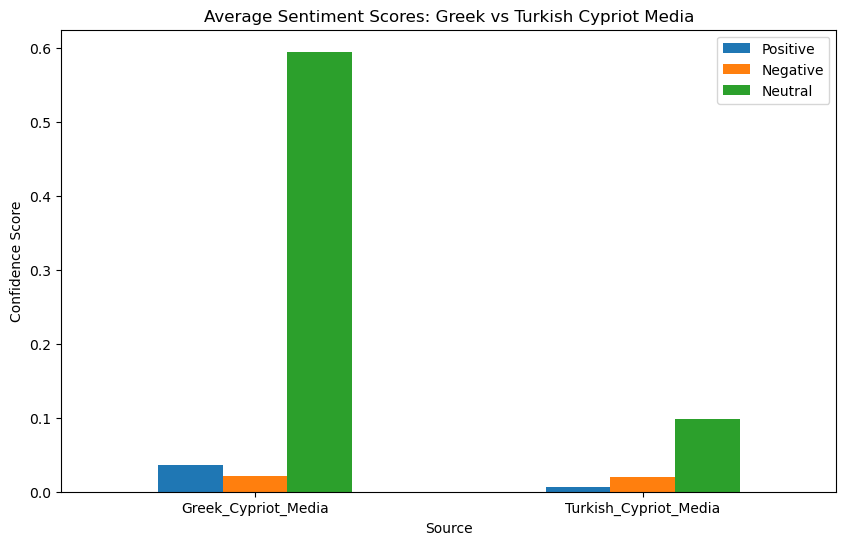

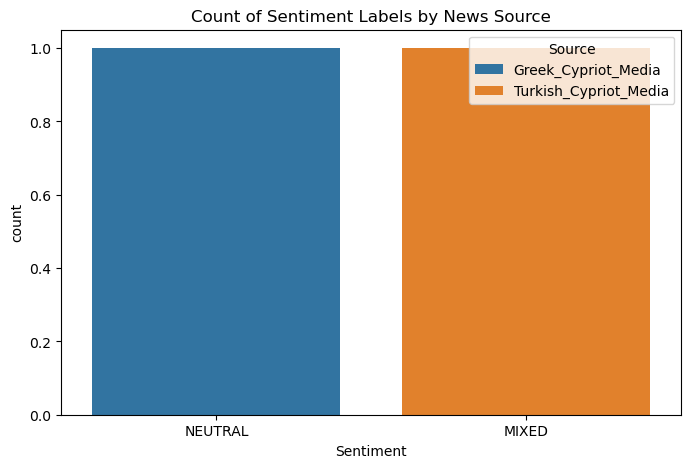

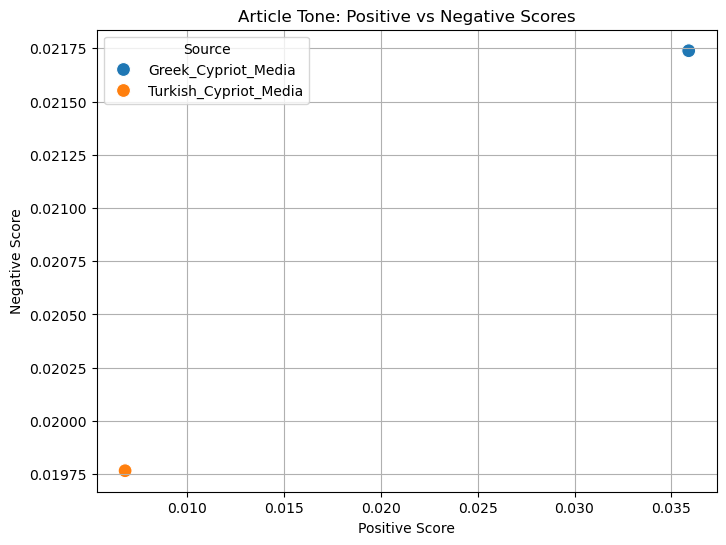

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv('final_results.csv')

# Chart 1: Average Sentiment Scores by Source
plt.figure(figsize=(10, 6))
avg_scores = df.groupby('Source')[['Positive', 'Negative', 'Neutral']].mean()
avg_scores.plot(kind='bar', figsize=(10,6))
plt.title('Average Sentiment Scores: Greek vs Turkish Cypriot Media')
plt.ylabel('Confidence Score')
plt.xticks(rotation=0)
plt.savefig('chart_1_sentiment_comparison.png')
plt.show()

# Chart 2: Sentiment Distribution (Count)
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', hue='Source', data=df)
plt.title('Count of Sentiment Labels by News Source')
plt.savefig('chart_2_sentiment_distribution.png')
plt.show()

# Chart 3: Positivity vs Negativity Scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Positive', y='Negative', hue='Source', s=100)
plt.title('Article Tone: Positive vs Negative Scores')
plt.xlabel('Positive Score')
plt.ylabel('Negative Score')
plt.grid(True)
plt.savefig('chart_3_scatter.png')
plt.show()